<a href="https://colab.research.google.com/github/Basu8971/Materraproject/blob/main/soilmoisture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

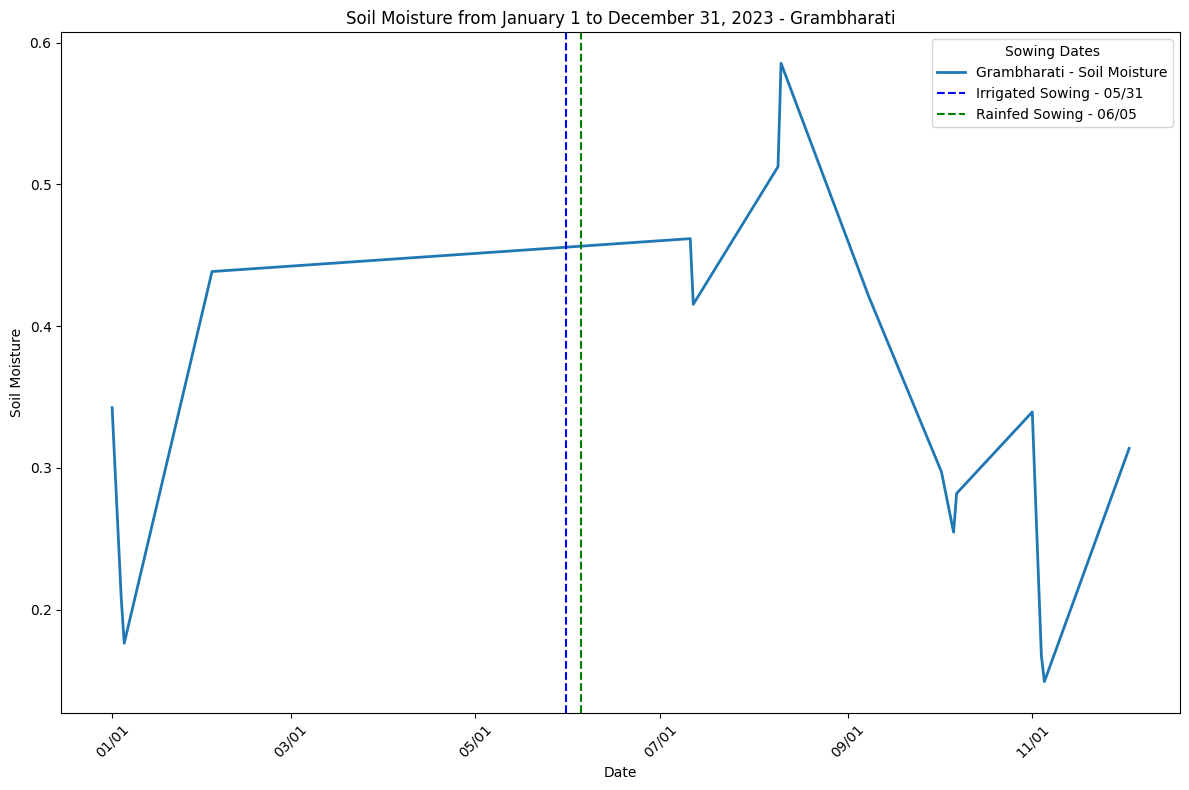


Grambharati - Available Soil Moisture Values:
         Date  Soil_moisture
0  2023-01-01       0.342517
1  2023-01-04       0.208429
2  2023-01-05       0.176406
3  2023-02-03       0.438519
4  2023-07-11       0.461712
5  2023-07-12       0.415398
6  2023-08-09       0.512502
7  2023-08-10       0.585394
8  2023-09-08       0.420780
9  2023-10-02       0.297199
10 2023-10-06       0.254715
11 2023-10-07       0.282046
12 2023-11-01       0.339512
13 2023-11-04       0.167697
14 2023-11-05       0.149332
15 2023-12-03       0.313808


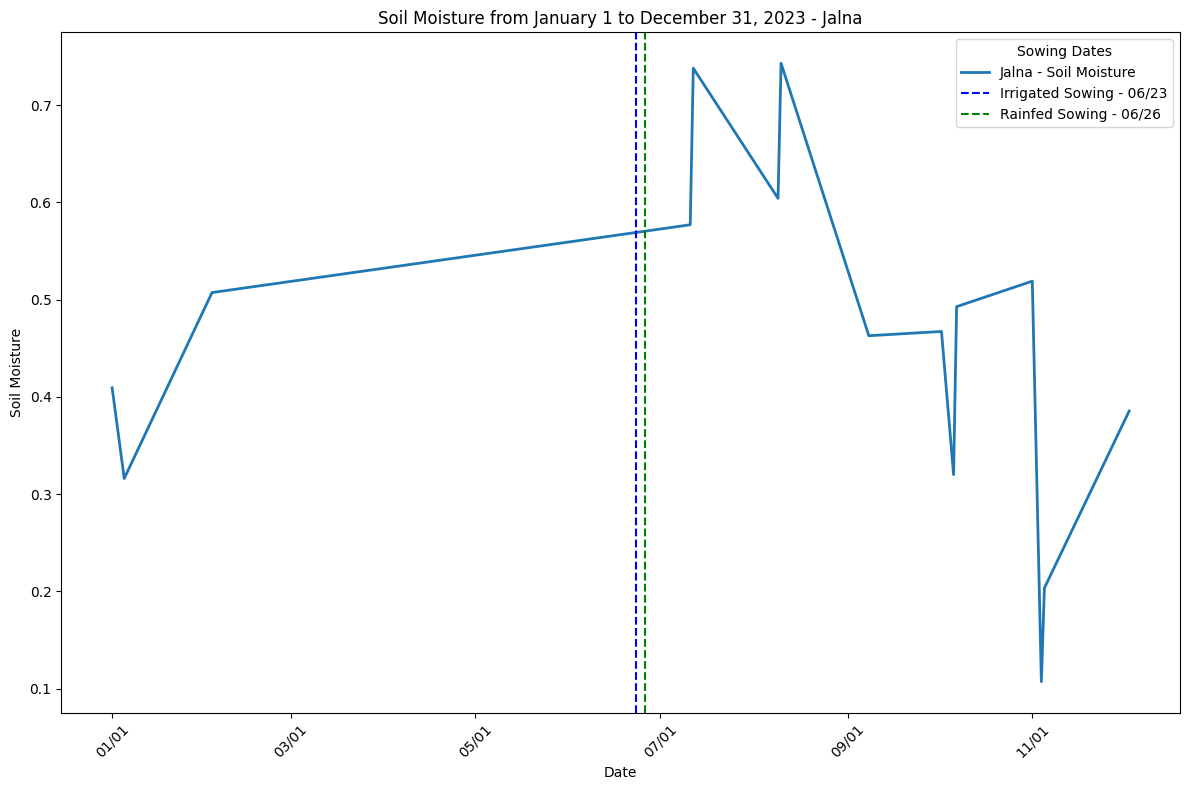


Jalna - Available Soil Moisture Values:
         Date  Soil_moisture
16 2023-01-01       0.409344
17 2023-01-05       0.316021
18 2023-02-03       0.507286
19 2023-07-11       0.577021
20 2023-07-12       0.738089
21 2023-08-09       0.604214
22 2023-08-10       0.743173
23 2023-09-08       0.462890
24 2023-10-02       0.467260
25 2023-10-06       0.320024
26 2023-10-07       0.492791
27 2023-11-01       0.519026
28 2023-11-04       0.107079
29 2023-11-05       0.203359
30 2023-12-03       0.385397


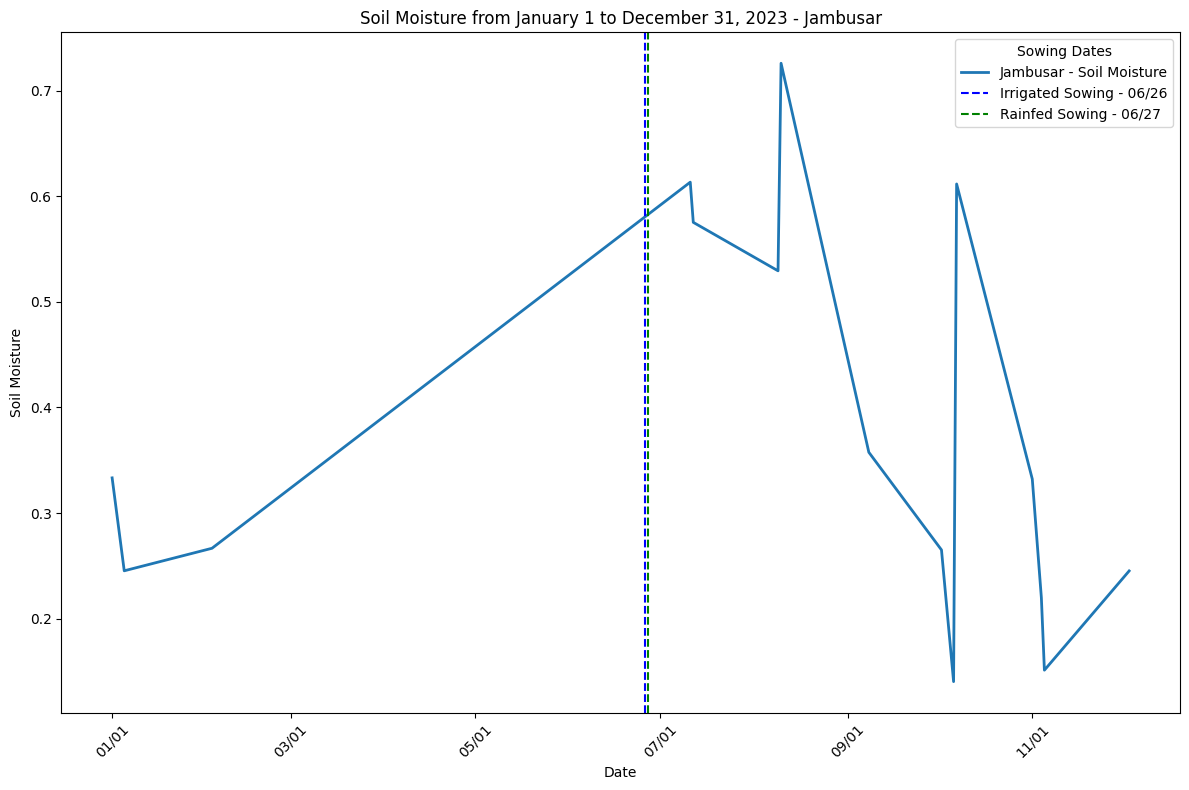


Jambusar - Available Soil Moisture Values:
         Date  Soil_moisture
31 2023-01-01       0.333320
32 2023-01-05       0.245305
33 2023-02-03       0.266643
34 2023-07-11       0.613397
35 2023-07-12       0.575340
36 2023-08-09       0.529428
37 2023-08-10       0.726029
38 2023-09-08       0.357544
39 2023-10-02       0.265072
40 2023-10-06       0.140334
41 2023-10-07       0.611695
42 2023-11-01       0.332162
43 2023-11-04       0.219763
44 2023-11-05       0.151176
45 2023-12-03       0.245180


KeyError: 'Farmer'

In [37]:
# Step 1: Install necessary libraries (if not already installed)
!pip install --upgrade gspread google-auth pandas matplotlib seaborn

# Step 2: Authenticate with Google using google-auth
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Authenticate the Google account
auth.authenticate_user()

# Use google-auth to get credentials and authorize gspread
creds, _ = default()
gc = gspread.authorize(creds)

# Step 3: Access Google Sheets using URLs
soil_moisture_sheet_url = 'https://docs.google.com/spreadsheets/d/1pDn2C9NthsvFSCnXoyOLD0Tx4G2y96bYbcom4H5lKhs/edit?gid=1431279503#gid=1431279503'

# Open the Google Sheet using gspread
soil_moisture_sheet = gc.open_by_url(soil_moisture_sheet_url)

# Load the data from the sheet into DataFrame
soil_moisture_data = pd.DataFrame(soil_moisture_sheet.sheet1.get_all_records())  # Soil Moisture data

# Step 4: Clean and process the data (strip extra spaces)
soil_moisture_data.columns = soil_moisture_data.columns.str.strip()

# Step 5: Convert 'Date' to datetime format
soil_moisture_data['Date'] = pd.to_datetime(soil_moisture_data['Date'], errors='coerce')

# Step 6: Filter data for the full year range (January 1 to December 31, 2023)
filtered_soil_data = soil_moisture_data[(soil_moisture_data['Date'].dt.year == 2023)]

# Step 7: Group by Location, FarmerName, and Date, then calculate the average soil moisture for each farmer
farmer_groups = filtered_soil_data.groupby(['Location', 'FarmerName', 'Date'])['Soil_moisture'].mean().reset_index()

# Step 8: Now, aggregate the data by Location, taking the average of all farmers for each location and date
location_groups = farmer_groups.groupby(['Location', 'Date'])['Soil_moisture'].mean().reset_index()

# Step 9: Create separate plots for each location
locations = location_groups['Location'].unique()

for location in locations:
    # Filter data for each location
    location_data = location_groups[location_groups['Location'] == location]

    # Plot the available soil moisture data for this location
    plt.figure(figsize=(12, 8))
    plt.plot(location_data['Date'], location_data['Soil_moisture'], label=f'{location} - Soil Moisture', linewidth=2)

    # Add vertical lines for the sowing dates (irrigated and rainfed)
    if location in sowing_dates:
        for crop_type, sowing_date in sowing_dates[location].items():
            sowing_date_datetime = pd.to_datetime(f"2023-{sowing_date}")
            plt.axvline(x=sowing_date_datetime, color='g' if crop_type == 'Rainfed' else 'b', linestyle='--', label=f'{crop_type} Sowing - {sowing_date_datetime.strftime("%m/%d")}')

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Soil Moisture')
    plt.title(f'Soil Moisture from January 1 to December 31, 2023 - {location}')

    # Format the x-axis to display only Month/Day (e.g., 01/01, 12/31)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

    # Set x-axis limits to show only the available dates (based on the data)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add a legend
    plt.legend(title='Sowing Dates')

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Print available dates and corresponding soil moisture values for the location
    print(f"\n{location} - Available Soil Moisture Values:")
    print(location_data[['Date', 'Soil_moisture']])







# Step 7: Group by Location and Farmer, then calculate the average soil moisture for each farmer
# This assumes that 'Farmer' is a column in the dataset. If it's different, replace 'Farmer' with the correct column name.
farmer_groups = filtered_soil_data.groupby(['Location', 'Farmer', 'Date'])['Soil_moisture'].mean().reset_index()

# Step 8: Now, aggregate the data by Location, taking the average of all farmers for each location and date
location_groups = farmer_groups.groupby(['Location', 'Date'])['Soil_moisture'].mean().reset_index()

# Step 9: Define the sowing dates for irrigated and rainfed
sowing_dates = {
    'Grambharati': {'Irrigated': '05-31', 'Rainfed': '06-05'},
    'Jalna': {'Irrigated': '06-23', 'Rainfed': '06-26'},
    'Jambusar': {'Irrigated': '06-26', 'Rainfed': '06-27'}
}

# Step 10: Create separate plots for each location
locations = location_groups['Location'].unique()

for location in locations:
    # Filter data for each location
    location_data = location_groups[location_groups['Location'] == location]

    # Plot the available soil moisture data for this location
    plt.figure(figsize=(12, 8))
    plt.plot(location_data['Date'], location_data['Soil_moisture'], label=f'{location} - Soil Moisture', linewidth=2)

    # Add vertical lines for the sowing dates (irrigated and rainfed)
    if location in sowing_dates:
        for crop_type, sowing_date in sowing_dates[location].items():
            sowing_date_datetime = pd.to_datetime(f"2023-{sowing_date}")
            plt.axvline(x=sowing_date_datetime, color='g' if crop_type == 'Rainfed' else 'b', linestyle='--', label=f'{crop_type} Sowing - {sowing_date_datetime.strftime("%m/%d")}')

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Soil Moisture')
    plt.title(f'Soil Moisture from January 1 to December 31, 2023 - {location}')

    # Format the x-axis to display only Month/Day (e.g., 01/01, 12/31)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

    # Set x-axis ticks to only available dates for this location
    plt.xticks(location_data['Date'], rotation=45)

    # Add a legend
    plt.legend(title='Sowing Dates')

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Print available dates and corresponding soil moisture values for the location
    print(f"\n{location} - Available Soil Moisture Values:")
    print(location_data[['Date', 'Soil_moisture']])
